# this notebook covers personlity analysis based on text using (MBTI) psychological model by making 4 models for each spectrum/field.


### the notebook goes through:
- #### Discovering data, cleaning it.
- #### Constucting models.
- #### Training models.
- #### Testing  models and evaluating their results.
- #### Calculating some metrics like confusion matrix.


#### Importing packages and libraries for prepocessing


In [ ]:
# Needed to install first
!pip install transformers
# Packages needed to be downloaded once
import nltk           # used for cleaning the dataset
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('stopwords')
nltk.download('wordnet')

# lists of words needed to be loaded once
stop_words = set(nltk.corpus.stopwords.words('english'))
# for lemmatization
wnl = nltk.WordNetLemmatizer()

     |████████████████████████████████| 2.6 MB 5.2 MB/s 
     |████████████████████████████████| 3.3 MB 37.1 MB/s 
     |████████████████████████████████| 895 kB 45.0 MB/s 
     |████████████████████████████████| 636 kB 34.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.

#### importing packages and libraries for maths, plots and file access

In [ ]:
# Global imports
import numpy as np            # linear algebra
import pandas as pd           # data processing, CSV file I/O 
import os                     # to access files on hard disk
import collections            # used for faster STL dictionaries and queues
import transformers as tf     # the main framework/library for training the AI model
import matplotlib.pyplot as plt   # for plotting
import csv                    # for handling csv files
import string                 # data cleansing
import re                     # data cleansing
from tensorflow.keras.preprocessing.text import Tokenizer         # for tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences # for padding the sequences
from sklearn.model_selection import train_test_split



#### making google colab accesses google drive

In [ ]:
# Access drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### checking if the file exists or not, if so load it.

In [ ]:
# Read data
# As readme suggests, download the dataset kaagle.csv first.
if not os.path.exists("drive/MyDrive/kaggle.csv"):
  print ("Error 101: Data does not exist! Download it first.")
data = pd.read_csv("drive/MyDrive/kaggle.csv")



#### showing some data statistics

In [ ]:
# Preview data summary
data.describe()

,split,id
count,8675.000000,8675.000000
mean,3.992392,4337.000000
std,2.563591,2504.401126
min,0.000000,0.000000
25%,2.000000,2168.500000
50%,4.000000,4337.000000
75%,6.000000,6505.500000
max,8.000000,8674.000000


#### showing first 10 samples of the data

In [ ]:
# data shape and content
print(f'Shape of data: {data.shape}')
data.head(10)

Shape of data: (8675, 4)


,type,text,split,id
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,5,0
1,ENTP,'I'm finding the lack of me in these posts ver...,4,1
2,INTP,'Good one _____ https://www.youtube.com/wat...,2,2
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",2,3
4,ENTJ,'You're fired.|||That's another silly misconce...,1,4
5,INTJ,'18/37 @.@|||Science is not perfect. No scien...,8,5
6,INFJ,"'No, I can't draw on my own nails (haha). Thos...",0,6
7,INTJ,'I tend to build up a collection of things on ...,5,7
8,INFJ,"I'm not sure, that's a good question. The dist...",0,8
9,INTP,'https://www.youtube.com/watch?v=w8-egj0y8Qs||...,5,9


#### saving the proportions/ratio of each class of the data

In [ ]:
# id and split are not important, remove them
data = data.iloc[:,:2]
# types
types = np.unique(data.type.values)
# the actual existence of proportional types
MBTI_TO_FREQUENCY_DICT_ACTUAL = {
    "ISTJ": 0.11,
    "ISFJ": 0.09,
    "INFJ": 0.04,
    "INTJ": 0.05,
    "ISTP": 0.05,
    "ISFP": 0.05,
    "INFP": 0.06,
    "INTP": 0.06,
    "ESTP": 0.04,
    "ESFP": 0.04,
    "ENFP": 0.08,
    "ENTP": 0.06,
    "ESTJ": 0.08,
    "ESFJ": 0.09,
    "ENFJ": 0.05,
    "ENTJ": 0.05,
}

#### plotting the histogram of the data classes

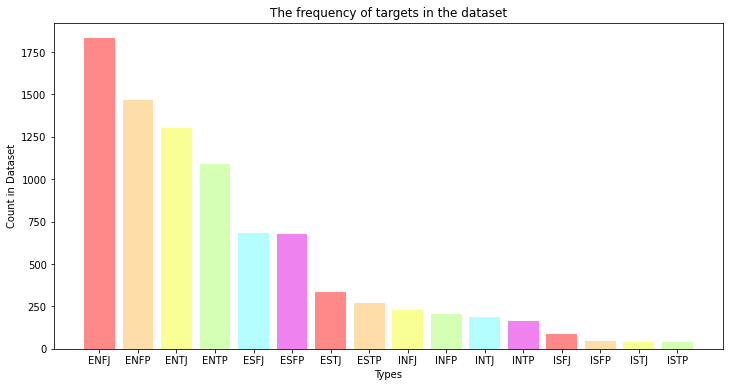

In [ ]:
# Data statistics
# Plot distribiution of data

def plot_count():
  # First, count each type of the 16
  counts = collections.defaultdict(int)
  for mbti in data["type"]:
      counts[mbti] += 1

  freq = {}
  size = data.shape[0]
  for mbti in types:
    freq[mbti] = counts[mbti]/size

  colors = ['#ff8888', "#ffdda8", "#f9ff93", "#d5ffb5", "#b3fdff", "violet" ]
  counts_sorted = sorted(counts.values(), reverse=True) 
  plt.rcParams["figure.figsize"] = (12, 6)
  plt.bar(types, counts_sorted, color=colors)
  plt.xlabel("Types")
  plt.ylabel("Count in Dataset")
  plt.title("The frequency of targets in the dataset")
  plt.savefig(dpi=150, fname="freq_of_targets.jpg")
  plt.show()

plot_count()

#### converting biased data into unbiased and noramlized one

In [ ]:
# Handling the skew of data compared to its originally expected values

def store_cleaned_data():
  # Then, count the least portion of it, compared to its real/actual value
  limiting_type = None
  min_size = float("infinity")
  for mbti in counts.keys():
      size = counts[mbti] / MBTI_TO_FREQUENCY_DICT_ACTUAL[mbti]
      if size < min_size:
          min_size = size
          limiting_type = mbti

  # Store dataset as default dictionary
  dic = collections.defaultdict(list)
  for index, row in data.iterrows():
      dic[row["type"]].append(row)

  # Save clean dataset for later processing
  unclean_list = []
  if not os.path.exists("drive/MyDrive/data_csv"):
    os.mkdir("drive/MyDrive/data_csv")
  with open("drive/MyDrive/data_csv/data_clean.csv", "w") as f:
      writer = csv.writer(f)
      writer.writerow(["type", "text"])

      for mbti in MBTI_TO_FREQUENCY_DICT_ACTUAL.keys():
          list1 = dic[mbti]
          for x in range(0, int(round(min_size * MBTI_TO_FREQUENCY_DICT_ACTUAL[mbti]))):
              writer.writerow(list1[x])
          unclean_list.append(
              list1[int(round(min_size * MBTI_TO_FREQUENCY_DICT_ACTUAL[mbti])) : len(list1)]
          )

In [ ]:
import copy
# Fetch clean data
if not os.path.exists("drive/MyDrive/data_csv/data_clean.csv"):
  print ("Storing cleaned data...")
  store_cleaned_data()

data = pd.read_csv("drive/MyDrive/data_csv/data_clean.csv")
# data shape and content
print(f'Shape of data: {data.shape}')
data.head(10)

Shape of data: (465, 2)


,type,posts
0,ISTJ,'Newton's Universal Gravity Law. I mean seriou...
1,ISTJ,'I never understood for a long time why people...
2,ISTJ,"'If it's not what you expected, try browns ins..."
3,ISTJ,'0 at 29. Can't see why I should keep it a sec...
4,ISTJ,"'ISTJ in university here, currently employed a..."
5,ISTJ,'You can say that about a lot of online tests....
6,ISTJ,'When I am depressed I tend to totally stop ca...
7,ISTJ,'I really am coming to detest online dating si...
8,ISTJ,"I initially thought that she was INFP, as she ..."
9,ISTJ,'Her and I have known each other for over 4 ye...


#### plotting the data after converting to unbiased

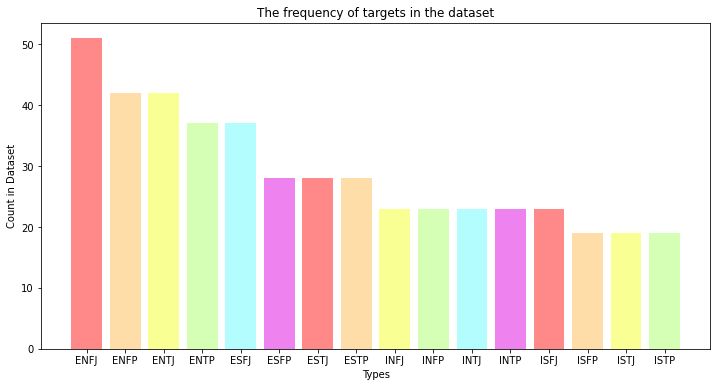

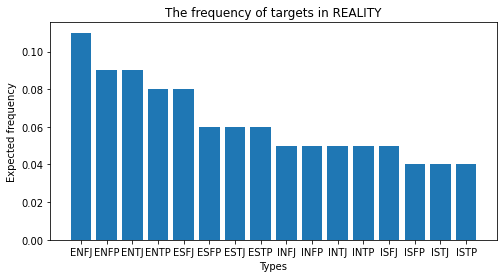

In [ ]:
plot_count()
# colors = ['#ff8888', "#ffdda8", "#f9ff93", "#d5ffb5", "#b3fdff", "violet" ]
freq_sorted = sorted(MBTI_TO_FREQUENCY_DICT_ACTUAL.values(), reverse=True) 
plt.rcParams["figure.figsize"] = (8,4)
plt.bar(types, freq_sorted)
plt.xlabel("Types")
plt.ylabel("Expected frequency")
plt.title("The frequency of targets in REALITY")
plt.show()

##### preprocessing the data by cleaning it (removing unwanted words, symbols,etc..)

In [ ]:
# Cleaning the remaining dataset
WORDS_TO_REMOVE = ["intj","intp","infj","infp","istj","istp","isfj","isfp","entj","entp","enfj","enfp","estj","estp","esfj","esfp","si","ni","ti","fi","se","ne","te","fe","nt","nf","sxsp","spsx","spso","sxso","sosp","sosx","sp","sx","sj","sf","st","le","socionic","socionics","enneagram","d","w","mbti"]
stop_words = list(stop_words) + WORDS_TO_REMOVE
def clean_text(text):
    regex = re.compile('[%s]' % re.escape('|'))
    text = regex.sub(" ", text)
    words = str(text).split()
    words = [i.lower() + " " for i in words]
    words = [i for i in words if not "http" in i]
    words = " ".join(words)
    words = words.translate(words.maketrans('', '', string.punctuation))
    #remove digits
    words = re.sub(" \d+", " ", words)
    
    words_tokens =  nltk.tokenize.word_tokenize(words)
    # remove the stop words
    filtered_tokens = [w for w in words_tokens if w not in stop_words]
    # remove redundent words
    filtered_tokens = list(dict.fromkeys(filtered_tokens))
    # remove single characters
    filtered_tokens = [w for w in filtered_tokens if len(w)>2]
    # lastly, lemmatization
    # lemmatization using WordNet Lemmatizer
    filtered_tokens = [wnl.lemmatize(w) for w in filtered_tokens]

    #combine words
    words = " ".join(filtered_tokens)

    return words

#### showing uncleaned data

In [ ]:
print("Unprocessed text\n\n")
data.text[0]

Unprocessed text




"'http://www.youtube.com/watch?v=qsXHcwe3krw|||http://41.media.tumblr.com/tumblr_lfouy03PMA1qa1rooo1_500.jpg|||enfp and intj moments  https://www.youtube.com/watch?v=iz7lE1g4XM4  sportscenter not top ten plays  https://www.youtube.com/watch?v=uCdfze1etec  pranks|||What has been the most life-changing experience in your life?|||http://www.youtube.com/watch?v=vXZeYwwRDw8   http://www.youtube.com/watch?v=u8ejam5DP3E  On repeat for most of today.|||May the PerC Experience immerse you.|||The last thing my INFJ friend posted on his facebook before committing suicide the next day. Rest in peace~   http://vimeo.com/22842206|||Hello ENFJ7. Sorry to hear of your distress. It's only natural for a relationship to not be perfection all the time in every moment of existence. Try to figure the hard times as times of growth, as...|||84389  84390  http://wallpaperpassion.com/upload/23700/friendship-boy-and-girl-wallpaper.jpg  http://assets.dornob.com/wp-content/uploads/2010/04/round-home-design.jpg ...

#### showing the cleaned data

In [ ]:
# Apply cleansing on dataset
data['cleaned_text'] = data['text'].apply(clean_text)
def get_type_index(string):
    return list(types).index(string)
data['type_index'] = data['type'].apply(get_type_index)

DATA_IMMUTE = copy.deepcopy(data)

print ("Cleaned text\n\n")
DATA_IMMUTE.cleaned_text[0]

Cleaned text




'moment sportscenter top ten play prank lifechanging experience life repeat today may perc immerse last thing friend posted facebook committing suicide next day rest peace hello enfj7 sorry hear distress natural relationship perfection time every moment existence try figure hard time growth welcome stuff game set match prozac wellbrutin least thirty minute moving leg dont mean sitting desk chair weed moderation maybe edible healthier alternative basically come three item youve determined type whichever type want would likely use given cognitive function whatnot left thing sims indeed video good one note somewhat subjective completely promoting death sim dear favorite game growing current cool appears late sad there someone everyone wait thought confidence cherish solitude revel within inner world whereas workin enjoy worry people always around lady youre complimentary personalitywell hey main social outlet xbox live conversation even verbally fatigue quickly really dig part banned thre

#### choosing some settings applied on data while training (vocab_size, trunc data from start or end, padding happens at start or end,etc...)

In [ ]:
# Tokeniation and padding
vocab_size = 2500
trunc_type = "post"
pad_type = "post"
oov_tok = "<OOV>"
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(data.cleaned_text.values)

In [ ]:
# tokenizer.word_counts

#### encoding labels to 0's and 1's to be used for training

In [ ]:

def split_classification(data, label):
  if label == 1:
    data["type"].replace({"ISTJ": 1, "ISFJ":1, "INFJ":1, "INTJ":1, "ISTP": 1, "ISFP": 1, "INFP": 1, "INTP": 1, "ESTP": 0, "ESFP": 0, "ENFP": 0, "ENTP": 0, "ESTJ": 0, "ESFJ": 0, "ENFJ": 0, "ENTJ": 0}, inplace=True)
  elif label == 2:
    data["type"].replace({"ISTJ": 1, "ISFJ":1, "INFJ":0, "INTJ":0, "ISTP": 1, "ISFP": 1, "INFP": 0, "INTP": 0, "ESTP": 1, "ESFP": 1, "ENFP": 0, "ENTP": 0, "ESTJ": 1, "ESFJ": 1, "ENFJ": 0, "ENTJ": 0}, inplace=True)
  elif label == 3:
    data["type"].replace({"ISTJ": 1, "ISFJ":0, "INFJ":0, "INTJ":1, "ISTP": 1, "ISFP": 0, "INFP": 0, "INTP": 1, "ESTP": 1, "ESFP": 0, "ENFP": 0, "ENTP": 1, "ESTJ": 1, "ESFJ": 0, "ENFJ": 0, "ENTJ": 1}, inplace=True)
  elif label == 4:
    data["type"].replace({"ISTJ": 0, "ISFJ":0, "INFJ":0, "INTJ":0, "ISTP": 1, "ISFP": 1, "INFP": 1, "INTP": 1, "ESTP": 1, "ESFP": 1, "ENFP": 1, "ENTP": 1, "ESTJ": 0, "ESFJ": 0, "ENFJ": 0, "ENTJ": 0}, inplace=True)
  else:
    print ("Dev Error: labels are 1 to 4 only")

#### spitting data for trainning and validation

In [ ]:


def data_split(label, large=False):
  if not large:
    split_classification(data, label)

  train, val = train_test_split(data ,test_size=0.2, random_state=42)

  print (f"Train shape: {train.shape}")
  print (f"Validation shape: {val.shape}")

  maxlen = 40
  train_sequences = tokenizer.texts_to_sequences(train.cleaned_text.values)
  train_padded = pad_sequences(train_sequences, maxlen = maxlen, truncating = trunc_type, padding = pad_type)

  val_sequences = tokenizer.texts_to_sequences(val.cleaned_text.values)
  val_padded = pad_sequences(val_sequences, maxlen = maxlen, truncating = trunc_type, padding = pad_type)
  
  if large:
    train_labels = tf.keras.utils.to_categorical(train.type_index.values, num_classes=16)
    val_labels= tf.keras.utils.to_categorical(val.type_index.values, num_classes=16)
  
  else:
    train_labels = train['type'].values
    val_labels = val['type'].values

  return train_padded, train_labels, val_padded, val_labels


#### calculating confusion matrix and accuracy

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score

def conf_mat (val_x, val_y, model,file_name):
  predictions = model.predict_classes(val_x)
  confusion = confusion_matrix(val_y, predictions)
  score = accuracy_score(val_y, predictions)
  if not os.path.exists("personality_analysis_results"): os.mkdir("personality_analysis_results")
  path = "personality_analysis_results/" + file_name+".txt"
  with open(path, 'w') as f:
    f.write("Total posts classified: {}\n".format(len(val_x)))
    f.write("Accuracy: {}\n".format(score))
    f.write("Confusion matrix: \n")
    f.write(np.array2string(confusion, separator=", "))

#### using glove for embeddings

In [ ]:
### Load glove into memory for embedding

GLOVE_PATH = "drive/MyDrive/glove.6B.50d.txt"
embeddings_index = dict()
with open(GLOVE_PATH) as f:
    for line in f:
        values = line.split()
        word = values[0]
        embeddings_index[word] = np.asarray(values[1:], dtype="float32")
print("Loaded {} word vectors.".format(len(embeddings_index)))

### Create a weight matrix for words
EMBEDDING_VECTOR_LENGTH = 50  #configurable
TOP_WORDS = vocab_size        #same as tokenizer 2500

embedding_matrix = np.zeros((TOP_WORDS, EMBEDDING_VECTOR_LENGTH))
for word, i in tokenizer.word_index.items():
    if i < TOP_WORDS:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

Loaded 400000 word vectors.


#### checking for tpu to use or not.

In [ ]:
use_tpu = True
strategy = None
model = None
import tensorflow as tf

if use_tpu:
    # Create distribution strategy
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    model = create_model()



INFO:absl:Entering into master device scope: /job:worker/replica:0/task:0/device:CPU:0


INFO:tensorflow:Initializing the TPU system: grpc://10.100.83.82:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.100.83.82:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


#### model architecture creation

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Flatten, Dropout, Conv1D, GlobalMaxPooling1D
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import GRU
from keras.layers import SimpleRNN
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.preprocessing import text
from keras.optimizers import Adam


def create_model(LEARNING_RATE = 0.01):
    MAX_POST_LENGTH = 40          #same as maxlen
    DROPOUT = 0.1                 #configurable
    LEARNING_RATE = LEARNING_RATE
    model = Sequential()

    # model.add(
    #     Embedding(
    #         TOP_WORDS,
    #         EMBEDDING_VECTOR_LENGTH,
    #         input_length=MAX_POST_LENGTH,
    #         weights=[embedding_matrix],
    #         mask_zero=True,
    #         trainable=True,
    #     )
    # )

    # model.add(SimpleRNN(EMBEDDING_VECTOR_LENGTH, dropout=DROPOUT, recurrent_dropout=DROPOUT, activation='sigmoid', kernel_initializer='zeros'))
    # model.add(GRU(EMBEDDING_VECTOR_LENGTH, dropout=DROPOUT, recurrent_dropout=DROPOUT, activation='sigmoid', kernel_initializer='zeros'))
    # model.add(
    #     LSTM(
    #         EMBEDDING_VECTOR_LENGTH,
    #         dropout=DROPOUT,
    #         recurrent_dropout=DROPOUT,
    #         activation="sigmoid",
    #         kernel_initializer="zeros",
    #     )
    # )
    
    # model.add(Bidirectional(LSTM(EMBEDDING_VECTOR_LENGTH, dropout=DROPOUT, recurrent_dropout=DROPOUT, activation='sigmoid', kernel_initializer='zeros')))
    
    # model.add(Dense(16, activation="softmax"))
    # optimizer = Adam(learning_rate=LEARNING_RATE, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
    # model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    # model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

    model.add(Embedding(TOP_WORDS, EMBEDDING_VECTOR_LENGTH, input_length=MAX_POST_LENGTH))
    # model.add(Dropout(0.1))
    model.add(Bidirectional(LSTM(EMBEDDING_VECTOR_LENGTH, return_sequences=False)))
    model.add(Dropout(0.1))
    # model.add(Bidirectional(LSTM(EMBEDDING_VECTOR_LENGTH,return_sequences=False)))
    # model.add(Dropout(0.1))
    # model.add(Bidirectional(LSTM(50)))
    # model.add(Dense(64, activation='relu'))
    model.add(Dense(16, activation='softmax'))
    op = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    model.compile(loss='categorical_crossentropy', optimizer=op, metrics=['accuracy'])
    return model



#### model summary, training with confusion matrix

In [ ]:
def run_model(label, result_folder, model_name,LEARNING_RATE=0.01, large=False):
  batch_size = 128
  # Create model
  model = None

  if strategy is not None:
    with strategy.scope():
      model = create_model(LEARNING_RATE)
    model.summary()

  print (f'Model id: {label}')
  train_x, train_y, val_x, val_y = data_split(label=label, large=large)
  print(f"Categorial split:")
  print(train_x)
  print(train_y)
  print(val_x)
  print(val_y)
  
  history = model.fit(train_x, train_y, epochs =1000, verbose = 1, 
            validation_data = (val_x, val_y),  batch_size = batch_size,
            callbacks = [tf.keras.callbacks.EarlyStopping(patience = 3)]
            )
  model_path = result_folder + '/' + model_name
  conf_mat(val_x, val_y , model, file_name=model_path)

In [ ]:
labels = [1,2,3,4]
if not os.path.exists("personality_analysis_results/lstm"): os.mkdir("personality_analysis_results/lstm")
model_names = ["conf_mat_lstm_01_IE", 
               "conf_mat_lstm_01_NS", 
               "conf_mat_lstm_01_FT",
               "conf_mat_lstm_01_PJ"]

for i in range (4):
  data = copy.deepcopy(DATA_IMMUTE)
  run_model(labels[i], "lstm", model_names[i])


Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 40, 50)            125000    
_________________________________________________________________
lstm_12 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 51        
Total params: 145,251
Trainable params: 145,251
Non-trainable params: 0
_________________________________________________________________
Model id: 1
   type  ...                                       cleaned_text
0  ISTJ  ...  newton universal gravity law mean seriously wo...
1  ISTJ  ...  never understood long time people often told s...
2  ISTJ  ...  expected try brown instead definitely prefer b...
3  ISTJ  ...  cant see keep secret fact could gone either wa...

[4 rows x 3 columns]
Train shape: (372, 3)
V

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]
INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


3/3 [==============================] - ETA: 0s - loss: 0.7011 - accuracy: 0.4907 

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


3/3 [==============================] - 14s 3s/step - loss: 0.7018 - accuracy: 0.4890 - val_loss: 0.7158 - val_accuracy: 0.4839
Epoch 2/1000
3/3 [==============================] - 1s 270ms/step - loss: 0.6948 - accuracy: 0.5188 - val_loss: 0.6926 - val_accuracy: 0.5269
Epoch 3/1000
3/3 [==============================] - 1s 287ms/step - loss: 0.6663 - accuracy: 0.7529 - val_loss: 0.6926 - val_accuracy: 0.5591
Epoch 4/1000
3/3 [==============================] - 1s 261ms/step - loss: 0.6206 - accuracy: 0.8323 - val_loss: 0.6967 - val_accuracy: 0.4731
Epoch 5/1000
3/3 [==============================] - 1s 266ms/step - loss: 0.5410 - accuracy: 0.9008 - val_loss: 0.7081 - val_accuracy: 0.4946


/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>]


Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 40, 50)            125000    
_________________________________________________________________
lstm_13 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 51        
Total params: 145,251
Trainable params: 145,251
Non-trainable params: 0
_________________________________________________________________
Model id: 2
   type  ...                                       cleaned_text
0  ISTJ  ...  newton universal gravity law mean seriously wo...
1  ISTJ  ...  never understood long time people often told s...
2  ISTJ  ...  expected try brown instead definitely prefer b...
3  ISTJ  ...  cant see keep secret fact could gone either wa...

[4 rows x 3 columns]
Train shape: (372, 3)
V

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]
INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


3/3 [==============================] - ETA: 0s - loss: 0.7250 - accuracy: 0.4609 

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


3/3 [==============================] - 13s 2s/step - loss: 0.7226 - accuracy: 0.4686 - val_loss: 0.6770 - val_accuracy: 0.5914
Epoch 2/1000
3/3 [==============================] - 1s 300ms/step - loss: 0.6897 - accuracy: 0.5387 - val_loss: 0.6943 - val_accuracy: 0.5054
Epoch 3/1000
3/3 [==============================] - 1s 291ms/step - loss: 0.6617 - accuracy: 0.8052 - val_loss: 0.6898 - val_accuracy: 0.5484
Epoch 4/1000
3/3 [==============================] - 1s 323ms/step - loss: 0.6079 - accuracy: 0.8715 - val_loss: 0.6920 - val_accuracy: 0.5269


/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>]


Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 40, 50)            125000    
_________________________________________________________________
lstm_14 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 51        
Total params: 145,251
Trainable params: 145,251
Non-trainable params: 0
_________________________________________________________________
Model id: 3
   type  ...                                       cleaned_text
0  ISTJ  ...  newton universal gravity law mean seriously wo...
1  ISTJ  ...  never understood long time people often told s...
2  ISTJ  ...  expected try brown instead definitely prefer b...
3  ISTJ  ...  cant see keep secret fact could gone either wa...

[4 rows x 3 columns]
Train shape: (372, 3)
V

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]
INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


3/3 [==============================] - ETA: 0s - loss: 0.7299 - accuracy: 0.4764 

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


3/3 [==============================] - 14s 2s/step - loss: 0.7273 - accuracy: 0.4783 - val_loss: 0.7130 - val_accuracy: 0.4731
Epoch 2/1000
3/3 [==============================] - 1s 260ms/step - loss: 0.6921 - accuracy: 0.5381 - val_loss: 0.6846 - val_accuracy: 0.5806
Epoch 3/1000
3/3 [==============================] - 1s 252ms/step - loss: 0.6611 - accuracy: 0.6088 - val_loss: 0.6781 - val_accuracy: 0.5914
Epoch 4/1000
3/3 [==============================] - 1s 265ms/step - loss: 0.6057 - accuracy: 0.7958 - val_loss: 0.6732 - val_accuracy: 0.5914
Epoch 5/1000
3/3 [==============================] - 1s 257ms/step - loss: 0.5279 - accuracy: 0.8663 - val_loss: 0.6926 - val_accuracy: 0.5591
Epoch 6/1000
3/3 [==============================] - 1s 262ms/step - loss: 0.4219 - accuracy: 0.8676 - val_loss: 0.7239 - val_accuracy: 0.5699
Epoch 7/1000
3/3 [==============================] - 1s 265ms/step - loss: 0.2876 - accuracy: 0.8961 - val_loss: 0.8386 - val_accuracy: 0.5806


/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>]


Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 40, 50)            125000    
_________________________________________________________________
lstm_15 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 51        
Total params: 145,251
Trainable params: 145,251
Non-trainable params: 0
_________________________________________________________________
Model id: 4
   type  ...                                       cleaned_text
0  ISTJ  ...  newton universal gravity law mean seriously wo...
1  ISTJ  ...  never understood long time people often told s...
2  ISTJ  ...  expected try brown instead definitely prefer b...
3  ISTJ  ...  cant see keep secret fact could gone either wa...

[4 rows x 3 columns]
Train shape: (372, 3)
V

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]
INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


3/3 [==============================] - ETA: 0s - loss: 0.7435 - accuracy: 0.4302 

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


3/3 [==============================] - 13s 2s/step - loss: 0.7391 - accuracy: 0.4382 - val_loss: 0.6475 - val_accuracy: 0.6667
Epoch 2/1000
3/3 [==============================] - 1s 283ms/step - loss: 0.6856 - accuracy: 0.5454 - val_loss: 0.6745 - val_accuracy: 0.6667
Epoch 3/1000
3/3 [==============================] - 1s 280ms/step - loss: 0.6666 - accuracy: 0.6570 - val_loss: 0.7082 - val_accuracy: 0.4301
Epoch 4/1000
3/3 [==============================] - 1s 293ms/step - loss: 0.6263 - accuracy: 0.8107 - val_loss: 0.6888 - val_accuracy: 0.5376


/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>]


#### Trainning using LSTM using learning rate 0.001

In [ ]:
model_names = ["conf_mat_lstm_001_IE", 
               "conf_mat_lstm_001_NS", 
               "conf_mat_lstm_001_FT",
               "conf_mat_lstm_001_PJ"]
if not os.path.exists("personality_analysis_results/lstm"): os.mkdir("personality_analysis_results/lstm")

for i in range (4):
  data = copy.deepcopy(DATA_IMMUTE)
  run_model(i+1, "lstm", model_names[i])


Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 40, 50)            125000    
_________________________________________________________________
lstm_16 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 51        
Total params: 145,251
Trainable params: 145,251
Non-trainable params: 0
_________________________________________________________________
Model id: 1
   type  ...                                       cleaned_text
0  ISTJ  ...  newton universal gravity law mean seriously wo...
1  ISTJ  ...  never understood long time people often told s...
2  ISTJ  ...  expected try brown instead definitely prefer b...
3  ISTJ  ...  cant see keep secret fact could gone either wa...

[4 rows x 3 columns]
Train shape: (372, 3)
V

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]
INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


3/3 [==============================] - ETA: 0s - loss: 0.6970 - accuracy: 0.4807 

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


3/3 [==============================] - 14s 2s/step - loss: 0.6968 - accuracy: 0.4808 - val_loss: 0.6951 - val_accuracy: 0.4839
Epoch 2/1000
3/3 [==============================] - 1s 283ms/step - loss: 0.6924 - accuracy: 0.4940 - val_loss: 0.6973 - val_accuracy: 0.4839
Epoch 3/1000
3/3 [==============================] - 1s 274ms/step - loss: 0.6894 - accuracy: 0.5286 - val_loss: 0.6991 - val_accuracy: 0.4839
Epoch 4/1000
3/3 [==============================] - 1s 274ms/step - loss: 0.6883 - accuracy: 0.5188 - val_loss: 0.6963 - val_accuracy: 0.5054


/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>]


Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, 40, 50)            125000    
_________________________________________________________________
lstm_17 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 51        
Total params: 145,251
Trainable params: 145,251
Non-trainable params: 0
_________________________________________________________________
Model id: 2
   type  ...                                       cleaned_text
0  ISTJ  ...  newton universal gravity law mean seriously wo...
1  ISTJ  ...  never understood long time people often told s...
2  ISTJ  ...  expected try brown instead definitely prefer b...
3  ISTJ  ...  cant see keep secret fact could gone either wa...

[4 rows x 3 columns]
Train shape: (372, 3)
V

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]
INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


3/3 [==============================] - ETA: 0s - loss: 0.6993 - accuracy: 0.5486 

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


3/3 [==============================] - 13s 2s/step - loss: 0.6995 - accuracy: 0.5465 - val_loss: 0.6772 - val_accuracy: 0.5914
Epoch 2/1000
3/3 [==============================] - 1s 275ms/step - loss: 0.6831 - accuracy: 0.5579 - val_loss: 0.6855 - val_accuracy: 0.5914
Epoch 3/1000
3/3 [==============================] - 1s 269ms/step - loss: 0.6883 - accuracy: 0.5557 - val_loss: 0.6916 - val_accuracy: 0.5161
Epoch 4/1000
3/3 [==============================] - 1s 256ms/step - loss: 0.6885 - accuracy: 0.5502 - val_loss: 0.6867 - val_accuracy: 0.6129


/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>]


Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, 40, 50)            125000    
_________________________________________________________________
lstm_18 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 51        
Total params: 145,251
Trainable params: 145,251
Non-trainable params: 0
_________________________________________________________________
Model id: 3
   type  ...                                       cleaned_text
0  ISTJ  ...  newton universal gravity law mean seriously wo...
1  ISTJ  ...  never understood long time people often told s...
2  ISTJ  ...  expected try brown instead definitely prefer b...
3  ISTJ  ...  cant see keep secret fact could gone either wa...

[4 rows x 3 columns]
Train shape: (372, 3)
V

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]
INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


3/3 [==============================] - ETA: 0s - loss: 0.7285 - accuracy: 0.5031 

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


3/3 [==============================] - 13s 2s/step - loss: 0.7269 - accuracy: 0.5037 - val_loss: 0.7142 - val_accuracy: 0.4731
Epoch 2/1000
3/3 [==============================] - 1s 257ms/step - loss: 0.6956 - accuracy: 0.5125 - val_loss: 0.6965 - val_accuracy: 0.4409
Epoch 3/1000
3/3 [==============================] - 1s 265ms/step - loss: 0.6875 - accuracy: 0.5697 - val_loss: 0.6924 - val_accuracy: 0.5591
Epoch 4/1000
3/3 [==============================] - 1s 265ms/step - loss: 0.6900 - accuracy: 0.5425 - val_loss: 0.6930 - val_accuracy: 0.5054
Epoch 5/1000
3/3 [==============================] - 1s 293ms/step - loss: 0.6859 - accuracy: 0.5343 - val_loss: 0.6931 - val_accuracy: 0.5054
Epoch 6/1000
3/3 [==============================] - 1s 267ms/step - loss: 0.6895 - accuracy: 0.5267 - val_loss: 0.6922 - val_accuracy: 0.5484
Epoch 7/1000
3/3 [==============================] - 1s 280ms/step - loss: 0.6834 - accuracy: 0.5637 - val_loss: 0.6925 - val_accuracy: 0.5699
Epoch 8/1000
3/3 [===

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>]


Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_19 (Embedding)     (None, 40, 50)            125000    
_________________________________________________________________
lstm_19 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 51        
Total params: 145,251
Trainable params: 145,251
Non-trainable params: 0
_________________________________________________________________
Model id: 4
   type  ...                                       cleaned_text
0  ISTJ  ...  newton universal gravity law mean seriously wo...
1  ISTJ  ...  never understood long time people often told s...
2  ISTJ  ...  expected try brown instead definitely prefer b...
3  ISTJ  ...  cant see keep secret fact could gone either wa...

[4 rows x 3 columns]
Train shape: (372, 3)
V

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]
INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


3/3 [==============================] - ETA: 0s - loss: 0.7098 - accuracy: 0.5381 

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


3/3 [==============================] - 14s 3s/step - loss: 0.7093 - accuracy: 0.5366 - val_loss: 0.6481 - val_accuracy: 0.6667
Epoch 2/1000
3/3 [==============================] - 1s 269ms/step - loss: 0.6909 - accuracy: 0.5357 - val_loss: 0.6687 - val_accuracy: 0.6667
Epoch 3/1000
3/3 [==============================] - 1s 287ms/step - loss: 0.6877 - accuracy: 0.5462 - val_loss: 0.6886 - val_accuracy: 0.5914
Epoch 4/1000
3/3 [==============================] - 1s 273ms/step - loss: 0.6875 - accuracy: 0.5670 - val_loss: 0.6967 - val_accuracy: 0.4409


/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>]


#### Training using LSTM using learning rate 0.001

In [ ]:
model_names = ["conf_mat_lstm_0001_IE", 
               "conf_mat_lstm_0001_NS", 
               "conf_mat_lstm_0001_FT",
               "conf_mat_lstm_0001_PJ"]
if not os.path.exists("personality_analysis_results/lstm"): os.mkdir("personality_analysis_results/lstm")

for i in range (4):
  data = copy.deepcopy(DATA_IMMUTE)
  run_model(i+1, "lstm", model_names[i])


Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_20 (Embedding)     (None, 40, 50)            125000    
_________________________________________________________________
lstm_20 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 51        
Total params: 145,251
Trainable params: 145,251
Non-trainable params: 0
_________________________________________________________________
Model id: 1
   type  ...                                       cleaned_text
0  ISTJ  ...  newton universal gravity law mean seriously wo...
1  ISTJ  ...  never understood long time people often told s...
2  ISTJ  ...  expected try brown instead definitely prefer b...
3  ISTJ  ...  cant see keep secret fact could gone either wa...

[4 rows x 3 columns]
Train shape: (372, 3)
V

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]
INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


3/3 [==============================] - ETA: 0s - loss: 0.7305 - accuracy: 0.4829 

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


3/3 [==============================] - 13s 2s/step - loss: 0.7302 - accuracy: 0.4831 - val_loss: 0.7123 - val_accuracy: 0.5161
Epoch 2/1000
3/3 [==============================] - 1s 291ms/step - loss: 0.7461 - accuracy: 0.4421 - val_loss: 0.7098 - val_accuracy: 0.5161
Epoch 3/1000
3/3 [==============================] - 1s 301ms/step - loss: 0.7134 - accuracy: 0.5066 - val_loss: 0.7077 - val_accuracy: 0.5161
Epoch 4/1000
3/3 [==============================] - 1s 273ms/step - loss: 0.7243 - accuracy: 0.4744 - val_loss: 0.7055 - val_accuracy: 0.5161
Epoch 5/1000
3/3 [==============================] - 1s 276ms/step - loss: 0.7253 - accuracy: 0.4617 - val_loss: 0.7036 - val_accuracy: 0.5161
Epoch 6/1000
3/3 [==============================] - 1s 288ms/step - loss: 0.7102 - accuracy: 0.4978 - val_loss: 0.7019 - val_accuracy: 0.5161
Epoch 7/1000
3/3 [==============================] - 1s 274ms/step - loss: 0.7101 - accuracy: 0.4890 - val_loss: 0.7003 - val_accuracy: 0.5161
Epoch 8/1000
3/3 [===

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>]


Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_21 (Embedding)     (None, 40, 50)            125000    
_________________________________________________________________
lstm_21 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 51        
Total params: 145,251
Trainable params: 145,251
Non-trainable params: 0
_________________________________________________________________
Model id: 2
   type  ...                                       cleaned_text
0  ISTJ  ...  newton universal gravity law mean seriously wo...
1  ISTJ  ...  never understood long time people often told s...
2  ISTJ  ...  expected try brown instead definitely prefer b...
3  ISTJ  ...  cant see keep secret fact could gone either wa...

[4 rows x 3 columns]
Train shape: (372, 3)
V

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]
INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


3/3 [==============================] - ETA: 0s - loss: 0.6914 - accuracy: 0.5382 

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


3/3 [==============================] - 14s 2s/step - loss: 0.6913 - accuracy: 0.5387 - val_loss: 0.6784 - val_accuracy: 0.5914
Epoch 2/1000
3/3 [==============================] - 1s 254ms/step - loss: 0.6931 - accuracy: 0.5319 - val_loss: 0.6788 - val_accuracy: 0.5914
Epoch 3/1000
3/3 [==============================] - 1s 283ms/step - loss: 0.6876 - accuracy: 0.5524 - val_loss: 0.6792 - val_accuracy: 0.5914
Epoch 4/1000
3/3 [==============================] - 1s 290ms/step - loss: 0.6918 - accuracy: 0.5348 - val_loss: 0.6795 - val_accuracy: 0.5914


/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>]


Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_22 (Embedding)     (None, 40, 50)            125000    
_________________________________________________________________
lstm_22 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 51        
Total params: 145,251
Trainable params: 145,251
Non-trainable params: 0
_________________________________________________________________
Model id: 3
   type  ...                                       cleaned_text
0  ISTJ  ...  newton universal gravity law mean seriously wo...
1  ISTJ  ...  never understood long time people often told s...
2  ISTJ  ...  expected try brown instead definitely prefer b...
3  ISTJ  ...  cant see keep secret fact could gone either wa...

[4 rows x 3 columns]
Train shape: (372, 3)
V

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]
INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


3/3 [==============================] - ETA: 0s - loss: 0.7780 - accuracy: 0.5125 

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


3/3 [==============================] - 13s 2s/step - loss: 0.7818 - accuracy: 0.5081 - val_loss: 0.7612 - val_accuracy: 0.5269
Epoch 2/1000
3/3 [==============================] - 1s 251ms/step - loss: 0.7879 - accuracy: 0.4954 - val_loss: 0.7561 - val_accuracy: 0.5269
Epoch 3/1000
3/3 [==============================] - 1s 270ms/step - loss: 0.7861 - accuracy: 0.4885 - val_loss: 0.7512 - val_accuracy: 0.5269
Epoch 4/1000
3/3 [==============================] - 1s 272ms/step - loss: 0.7909 - accuracy: 0.4768 - val_loss: 0.7465 - val_accuracy: 0.5269
Epoch 5/1000
3/3 [==============================] - 1s 262ms/step - loss: 0.7701 - accuracy: 0.4954 - val_loss: 0.7420 - val_accuracy: 0.5269
Epoch 6/1000
3/3 [==============================] - 1s 268ms/step - loss: 0.7781 - accuracy: 0.4778 - val_loss: 0.7378 - val_accuracy: 0.5269
Epoch 7/1000
3/3 [==============================] - 1s 256ms/step - loss: 0.7672 - accuracy: 0.4846 - val_loss: 0.7339 - val_accuracy: 0.5269
Epoch 8/1000
3/3 [===

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>]


Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_23 (Embedding)     (None, 40, 50)            125000    
_________________________________________________________________
lstm_23 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 51        
Total params: 145,251
Trainable params: 145,251
Non-trainable params: 0
_________________________________________________________________
Model id: 4
   type  ...                                       cleaned_text
0  ISTJ  ...  newton universal gravity law mean seriously wo...
1  ISTJ  ...  never understood long time people often told s...
2  ISTJ  ...  expected try brown instead definitely prefer b...
3  ISTJ  ...  cant see keep secret fact could gone either wa...

[4 rows x 3 columns]
Train shape: (372, 3)
V

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]
INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


3/3 [==============================] - ETA: 0s - loss: 0.6990 - accuracy: 0.5134 

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


3/3 [==============================] - 13s 2s/step - loss: 0.6978 - accuracy: 0.5181 - val_loss: 0.6577 - val_accuracy: 0.6667
Epoch 2/1000
3/3 [==============================] - 1s 255ms/step - loss: 0.6917 - accuracy: 0.5366 - val_loss: 0.6590 - val_accuracy: 0.6667
Epoch 3/1000
3/3 [==============================] - 1s 269ms/step - loss: 0.6860 - accuracy: 0.5581 - val_loss: 0.6603 - val_accuracy: 0.6667
Epoch 4/1000
3/3 [==============================] - 1s 274ms/step - loss: 0.6910 - accuracy: 0.5337 - val_loss: 0.6620 - val_accuracy: 0.6667


/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>]


#### Training using LSTM using learning rate 0.00001

In [ ]:
model_names = ["conf_mat_lstm_00001_IE", 
               "conf_mat_lstm_00001_NS", 
               "conf_mat_lstm_00001_FT",
               "conf_mat_lstm_00001_PJ"]
if not os.path.exists("personality_analysis_results/lstm"): os.mkdir("personality_analysis_results/lstm")

for i in range (4):
  data = copy.deepcopy(DATA_IMMUTE)
  run_model(i+1, "lstm", model_names[i])


Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_24 (Embedding)     (None, 40, 50)            125000    
_________________________________________________________________
lstm_24 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 51        
Total params: 145,251
Trainable params: 145,251
Non-trainable params: 0
_________________________________________________________________
Model id: 1
   type  ...                                       cleaned_text
0  ISTJ  ...  newton universal gravity law mean seriously wo...
1  ISTJ  ...  never understood long time people often told s...
2  ISTJ  ...  expected try brown instead definitely prefer b...
3  ISTJ  ...  cant see keep secret fact could gone either wa...

[4 rows x 3 columns]
Train shape: (372, 3)
V

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]
INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


3/3 [==============================] - ETA: 0s - loss: 0.7403 - accuracy: 0.5142 

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


3/3 [==============================] - 13s 2s/step - loss: 0.7454 - accuracy: 0.5066 - val_loss: 0.7392 - val_accuracy: 0.5161
Epoch 2/1000
3/3 [==============================] - 2s 810ms/step - loss: 0.7488 - accuracy: 0.5007 - val_loss: 0.7387 - val_accuracy: 0.5161
Epoch 3/1000
3/3 [==============================] - 1s 274ms/step - loss: 0.7627 - accuracy: 0.4802 - val_loss: 0.7383 - val_accuracy: 0.5161
Epoch 4/1000
3/3 [==============================] - 1s 259ms/step - loss: 0.7535 - accuracy: 0.4939 - val_loss: 0.7379 - val_accuracy: 0.5161
Epoch 5/1000
3/3 [==============================] - 1s 265ms/step - loss: 0.7551 - accuracy: 0.4900 - val_loss: 0.7375 - val_accuracy: 0.5161
Epoch 6/1000
3/3 [==============================] - 1s 272ms/step - loss: 0.7560 - accuracy: 0.4880 - val_loss: 0.7370 - val_accuracy: 0.5161
Epoch 7/1000
3/3 [==============================] - 1s 275ms/step - loss: 0.7473 - accuracy: 0.5007 - val_loss: 0.7366 - val_accuracy: 0.5161
Epoch 8/1000
3/3 [===

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>]


Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_25 (Embedding)     (None, 40, 50)            125000    
_________________________________________________________________
lstm_25 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 51        
Total params: 145,251
Trainable params: 145,251
Non-trainable params: 0
_________________________________________________________________
Model id: 2
   type  ...                                       cleaned_text
0  ISTJ  ...  newton universal gravity law mean seriously wo...
1  ISTJ  ...  never understood long time people often told s...
2  ISTJ  ...  expected try brown instead definitely prefer b...
3  ISTJ  ...  cant see keep secret fact could gone either wa...

[4 rows x 3 columns]
Train shape: (372, 3)
V

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]
INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


3/3 [==============================] - ETA: 0s - loss: 0.6896 - accuracy: 0.5434 

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


3/3 [==============================] - 14s 2s/step - loss: 0.6896 - accuracy: 0.5426 - val_loss: 0.6839 - val_accuracy: 0.5914
Epoch 2/1000
3/3 [==============================] - 1s 270ms/step - loss: 0.6905 - accuracy: 0.5387 - val_loss: 0.6838 - val_accuracy: 0.5914
Epoch 3/1000
3/3 [==============================] - 1s 266ms/step - loss: 0.6905 - accuracy: 0.5319 - val_loss: 0.6838 - val_accuracy: 0.5914
Epoch 4/1000
3/3 [==============================] - 1s 257ms/step - loss: 0.6882 - accuracy: 0.5534 - val_loss: 0.6837 - val_accuracy: 0.5914
Epoch 5/1000
3/3 [==============================] - 1s 269ms/step - loss: 0.6916 - accuracy: 0.5290 - val_loss: 0.6836 - val_accuracy: 0.5914
Epoch 6/1000
3/3 [==============================] - 1s 269ms/step - loss: 0.6917 - accuracy: 0.5250 - val_loss: 0.6836 - val_accuracy: 0.5914
Epoch 7/1000
3/3 [==============================] - 1s 274ms/step - loss: 0.6895 - accuracy: 0.5436 - val_loss: 0.6836 - val_accuracy: 0.5914
Epoch 8/1000
3/3 [===

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>]


Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_26 (Embedding)     (None, 40, 50)            125000    
_________________________________________________________________
lstm_26 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 51        
Total params: 145,251
Trainable params: 145,251
Non-trainable params: 0
_________________________________________________________________
Model id: 3
   type  ...                                       cleaned_text
0  ISTJ  ...  newton universal gravity law mean seriously wo...
1  ISTJ  ...  never understood long time people often told s...
2  ISTJ  ...  expected try brown instead definitely prefer b...
3  ISTJ  ...  cant see keep secret fact could gone either wa...

[4 rows x 3 columns]
Train shape: (372, 3)
V

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]
INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


3/3 [==============================] - ETA: 0s - loss: 0.6981 - accuracy: 0.4826 

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


3/3 [==============================] - 13s 2s/step - loss: 0.6976 - accuracy: 0.4856 - val_loss: 0.6918 - val_accuracy: 0.5269
Epoch 2/1000
3/3 [==============================] - 1s 255ms/step - loss: 0.6980 - accuracy: 0.4817 - val_loss: 0.6918 - val_accuracy: 0.5269
Epoch 3/1000
3/3 [==============================] - 1s 266ms/step - loss: 0.6932 - accuracy: 0.5149 - val_loss: 0.6918 - val_accuracy: 0.5269
Epoch 4/1000
3/3 [==============================] - 1s 266ms/step - loss: 0.6954 - accuracy: 0.4954 - val_loss: 0.6918 - val_accuracy: 0.5269
Epoch 5/1000
3/3 [==============================] - 1s 270ms/step - loss: 0.6945 - accuracy: 0.5071 - val_loss: 0.6918 - val_accuracy: 0.5269
Epoch 6/1000
3/3 [==============================] - 1s 264ms/step - loss: 0.6942 - accuracy: 0.5100 - val_loss: 0.6918 - val_accuracy: 0.5269
Epoch 7/1000
3/3 [==============================] - 1s 252ms/step - loss: 0.6960 - accuracy: 0.4944 - val_loss: 0.6918 - val_accuracy: 0.5269
Epoch 8/1000
3/3 [===

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>]


Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_27 (Embedding)     (None, 40, 50)            125000    
_________________________________________________________________
lstm_27 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 51        
Total params: 145,251
Trainable params: 145,251
Non-trainable params: 0
_________________________________________________________________
Model id: 4
   type  ...                                       cleaned_text
0  ISTJ  ...  newton universal gravity law mean seriously wo...
1  ISTJ  ...  never understood long time people often told s...
2  ISTJ  ...  expected try brown instead definitely prefer b...
3  ISTJ  ...  cant see keep secret fact could gone either wa...

[4 rows x 3 columns]
Train shape: (372, 3)
V

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]
INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


3/3 [==============================] - ETA: 0s - loss: 0.7314 - accuracy: 0.4762 

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


3/3 [==============================] - 13s 2s/step - loss: 0.7324 - accuracy: 0.4741 - val_loss: 0.7979 - val_accuracy: 0.3333
Epoch 2/1000
3/3 [==============================] - 1s 285ms/step - loss: 0.7354 - accuracy: 0.4682 - val_loss: 0.7971 - val_accuracy: 0.3333
Epoch 3/1000
3/3 [==============================] - 1s 267ms/step - loss: 0.7369 - accuracy: 0.4643 - val_loss: 0.7962 - val_accuracy: 0.3333
Epoch 4/1000
3/3 [==============================] - 1s 257ms/step - loss: 0.7302 - accuracy: 0.4780 - val_loss: 0.7953 - val_accuracy: 0.3333
Epoch 5/1000
3/3 [==============================] - 0s 241ms/step - loss: 0.7279 - accuracy: 0.4800 - val_loss: 0.7945 - val_accuracy: 0.3333
Epoch 6/1000
3/3 [==============================] - 1s 263ms/step - loss: 0.7267 - accuracy: 0.4809 - val_loss: 0.7937 - val_accuracy: 0.3333
Epoch 7/1000
3/3 [==============================] - 1s 254ms/step - loss: 0.7352 - accuracy: 0.4604 - val_loss: 0.7929 - val_accuracy: 0.3333
Epoch 8/1000
3/3 [===

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>]


#### Training using RNN

In [ ]:
model_names = ["conf_mat_rnn_01_IE", 
               "conf_mat_rnn_01_NS", 
               "conf_mat_rnn_01_FT",
               "conf_mat_rnn_01_PJ"]
if not os.path.exists("personality_analysis_results/rnn"): os.mkdir("personality_analysis_results/rnn")

for i in range (4):
  data = copy.deepcopy(DATA_IMMUTE)
  run_model(i+1, "rnn", model_names[i],LEARNING_RATE=0.01)


Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_28 (Embedding)     (None, 40, 50)            125000    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 50)                5050      
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 51        
Total params: 130,101
Trainable params: 130,101
Non-trainable params: 0
_________________________________________________________________
Model id: 1
   type  ...                                       cleaned_text
0  ISTJ  ...  newton universal gravity law mean seriously wo...
1  ISTJ  ...  never understood long time people often told s...
2  ISTJ  ...  expected try brown instead definitely prefer b...
3  ISTJ  ...  cant see keep secret fact could gone either wa...

[4 rows x 3 columns]
Train shape: (372, 3)
V

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]
INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


3/3 [==============================] - ETA: 0s - loss: 0.8808 - accuracy: 0.5319 

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


3/3 [==============================] - 10s 2s/step - loss: 0.8641 - accuracy: 0.5293 - val_loss: 0.7376 - val_accuracy: 0.5161
Epoch 2/1000
3/3 [==============================] - 1s 278ms/step - loss: 0.7837 - accuracy: 0.4822 - val_loss: 0.7145 - val_accuracy: 0.5161
Epoch 3/1000
3/3 [==============================] - 1s 278ms/step - loss: 0.6964 - accuracy: 0.5120 - val_loss: 0.6958 - val_accuracy: 0.5054
Epoch 4/1000
3/3 [==============================] - 1s 274ms/step - loss: 0.6560 - accuracy: 0.5890 - val_loss: 0.7356 - val_accuracy: 0.4839
Epoch 5/1000
3/3 [==============================] - 1s 267ms/step - loss: 0.6367 - accuracy: 0.5570 - val_loss: 0.7080 - val_accuracy: 0.4839
Epoch 6/1000
3/3 [==============================] - 1s 272ms/step - loss: 0.5855 - accuracy: 0.6907 - val_loss: 0.6889 - val_accuracy: 0.5484
Epoch 7/1000
3/3 [==============================] - 1s 279ms/step - loss: 0.5278 - accuracy: 0.7709 - val_loss: 0.6998 - val_accuracy: 0.5591
Epoch 8/1000
3/3 [===

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>]


Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_29 (Embedding)     (None, 40, 50)            125000    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 50)                5050      
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 51        
Total params: 130,101
Trainable params: 130,101
Non-trainable params: 0
_________________________________________________________________
Model id: 2
   type  ...                                       cleaned_text
0  ISTJ  ...  newton universal gravity law mean seriously wo...
1  ISTJ  ...  never understood long time people often told s...
2  ISTJ  ...  expected try brown instead definitely prefer b...
3  ISTJ  ...  cant see keep secret fact could gone either wa...

[4 rows x 3 columns]
Train shape: (372, 3)
V

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]
INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


3/3 [==============================] - ETA: 0s - loss: 0.7016 - accuracy: 0.5208 

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


3/3 [==============================] - 9s 2s/step - loss: 0.7018 - accuracy: 0.5243 - val_loss: 0.6942 - val_accuracy: 0.5161
Epoch 2/1000
3/3 [==============================] - 1s 273ms/step - loss: 0.6782 - accuracy: 0.5707 - val_loss: 0.6920 - val_accuracy: 0.5914
Epoch 3/1000
3/3 [==============================] - 1s 287ms/step - loss: 0.6532 - accuracy: 0.6415 - val_loss: 0.6875 - val_accuracy: 0.5806
Epoch 4/1000
3/3 [==============================] - 1s 269ms/step - loss: 0.6318 - accuracy: 0.6289 - val_loss: 0.7061 - val_accuracy: 0.4946
Epoch 5/1000
3/3 [==============================] - 1s 269ms/step - loss: 0.5872 - accuracy: 0.7141 - val_loss: 0.7056 - val_accuracy: 0.5914
Epoch 6/1000
3/3 [==============================] - 1s 270ms/step - loss: 0.5420 - accuracy: 0.7406 - val_loss: 0.7214 - val_accuracy: 0.5914


/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>]


Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_30 (Embedding)     (None, 40, 50)            125000    
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 50)                5050      
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 51        
Total params: 130,101
Trainable params: 130,101
Non-trainable params: 0
_________________________________________________________________
Model id: 3
   type  ...                                       cleaned_text
0  ISTJ  ...  newton universal gravity law mean seriously wo...
1  ISTJ  ...  never understood long time people often told s...
2  ISTJ  ...  expected try brown instead definitely prefer b...
3  ISTJ  ...  cant see keep secret fact could gone either wa...

[4 rows x 3 columns]
Train shape: (372, 3)
V

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]
INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


3/3 [==============================] - ETA: 0s - loss: 0.7257 - accuracy: 0.5000 

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


3/3 [==============================] - 9s 2s/step - loss: 0.7263 - accuracy: 0.5000 - val_loss: 0.7000 - val_accuracy: 0.4731
Epoch 2/1000
3/3 [==============================] - 1s 268ms/step - loss: 0.6887 - accuracy: 0.5600 - val_loss: 0.7001 - val_accuracy: 0.4946
Epoch 3/1000
3/3 [==============================] - 1s 277ms/step - loss: 0.6718 - accuracy: 0.5651 - val_loss: 0.7132 - val_accuracy: 0.4516
Epoch 4/1000
3/3 [==============================] - 1s 275ms/step - loss: 0.6413 - accuracy: 0.6753 - val_loss: 0.7162 - val_accuracy: 0.4839


/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>]


Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_31 (Embedding)     (None, 40, 50)            125000    
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 50)                5050      
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 51        
Total params: 130,101
Trainable params: 130,101
Non-trainable params: 0
_________________________________________________________________
Model id: 4
   type  ...                                       cleaned_text
0  ISTJ  ...  newton universal gravity law mean seriously wo...
1  ISTJ  ...  never understood long time people often told s...
2  ISTJ  ...  expected try brown instead definitely prefer b...
3  ISTJ  ...  cant see keep secret fact could gone either wa...

[4 rows x 3 columns]
Train shape: (372, 3)
V

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]
INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


3/3 [==============================] - ETA: 0s - loss: 0.8519 - accuracy: 0.4586 

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


3/3 [==============================] - 9s 2s/step - loss: 0.8375 - accuracy: 0.4642 - val_loss: 0.6421 - val_accuracy: 0.6667
Epoch 2/1000
3/3 [==============================] - 1s 269ms/step - loss: 0.7272 - accuracy: 0.5484 - val_loss: 0.6453 - val_accuracy: 0.6667
Epoch 3/1000
3/3 [==============================] - 1s 279ms/step - loss: 0.6526 - accuracy: 0.5912 - val_loss: 0.7233 - val_accuracy: 0.4301
Epoch 4/1000
3/3 [==============================] - 1s 300ms/step - loss: 0.6569 - accuracy: 0.6034 - val_loss: 0.7693 - val_accuracy: 0.3871


/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>]


In [ ]:
model_names = ["conf_mat_rnn_001_IE", 
               "conf_mat_rnn_001_NS", 
               "conf_mat_rnn_001_FT",
               "conf_mat_rnn_001_PJ"]
if not os.path.exists("personality_analysis_results/rnn"): os.mkdir("personality_analysis_results/rnn")

for i in range (4):
  data = copy.deepcopy(DATA_IMMUTE)
  run_model(i+1, "rnn", model_names[i],LEARNING_RATE=0.001)

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_32 (Embedding)     (None, 40, 50)            125000    
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, 50)                5050      
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 51        
Total params: 130,101
Trainable params: 130,101
Non-trainable params: 0
_________________________________________________________________
Model id: 1
   type  ...                                       cleaned_text
0  ISTJ  ...  newton universal gravity law mean seriously wo...
1  ISTJ  ...  never understood long time people often told s...
2  ISTJ  ...  expected try brown instead definitely prefer b...
3  ISTJ  ...  cant see keep secret fact could gone either wa...

[4 rows x 3 columns]
Train shape: (372, 3)
V

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]
INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


3/3 [==============================] - ETA: 0s - loss: 0.6953 - accuracy: 0.5249 

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


3/3 [==============================] - 9s 2s/step - loss: 0.6955 - accuracy: 0.5227 - val_loss: 0.6946 - val_accuracy: 0.4086
Epoch 2/1000
3/3 [==============================] - 1s 268ms/step - loss: 0.6914 - accuracy: 0.4924 - val_loss: 0.6944 - val_accuracy: 0.4731
Epoch 3/1000
3/3 [==============================] - 1s 284ms/step - loss: 0.6911 - accuracy: 0.5393 - val_loss: 0.6959 - val_accuracy: 0.4624
Epoch 4/1000
3/3 [==============================] - 1s 280ms/step - loss: 0.6896 - accuracy: 0.5453 - val_loss: 0.6998 - val_accuracy: 0.4946
Epoch 5/1000
3/3 [==============================] - 1s 279ms/step - loss: 0.6838 - accuracy: 0.5662 - val_loss: 0.6995 - val_accuracy: 0.4839


/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>]


Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_33 (Embedding)     (None, 40, 50)            125000    
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, 50)                5050      
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 51        
Total params: 130,101
Trainable params: 130,101
Non-trainable params: 0
_________________________________________________________________
Model id: 2
   type  ...                                       cleaned_text
0  ISTJ  ...  newton universal gravity law mean seriously wo...
1  ISTJ  ...  never understood long time people often told s...
2  ISTJ  ...  expected try brown instead definitely prefer b...
3  ISTJ  ...  cant see keep secret fact could gone either wa...

[4 rows x 3 columns]
Train shape: (372, 3)
V

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]
INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


3/3 [==============================] - ETA: 0s - loss: 0.8209 - accuracy: 0.5317 

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


3/3 [==============================] - 9s 2s/step - loss: 0.8158 - accuracy: 0.5338 - val_loss: 0.7103 - val_accuracy: 0.5914
Epoch 2/1000
3/3 [==============================] - 1s 263ms/step - loss: 0.7263 - accuracy: 0.5573 - val_loss: 0.6826 - val_accuracy: 0.5914
Epoch 3/1000
3/3 [==============================] - 1s 273ms/step - loss: 0.7121 - accuracy: 0.5387 - val_loss: 0.6747 - val_accuracy: 0.5914
Epoch 4/1000
3/3 [==============================] - 1s 276ms/step - loss: 0.6941 - accuracy: 0.5408 - val_loss: 0.6810 - val_accuracy: 0.5806
Epoch 5/1000
3/3 [==============================] - 1s 275ms/step - loss: 0.6858 - accuracy: 0.5523 - val_loss: 0.6902 - val_accuracy: 0.5269
Epoch 6/1000
3/3 [==============================] - 1s 269ms/step - loss: 0.6920 - accuracy: 0.5076 - val_loss: 0.6961 - val_accuracy: 0.4946


/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>]


Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_34 (Embedding)     (None, 40, 50)            125000    
_________________________________________________________________
simple_rnn_6 (SimpleRNN)     (None, 50)                5050      
_________________________________________________________________
dense_34 (Dense)             (None, 1)                 51        
Total params: 130,101
Trainable params: 130,101
Non-trainable params: 0
_________________________________________________________________
Model id: 3
   type  ...                                       cleaned_text
0  ISTJ  ...  newton universal gravity law mean seriously wo...
1  ISTJ  ...  never understood long time people often told s...
2  ISTJ  ...  expected try brown instead definitely prefer b...
3  ISTJ  ...  cant see keep secret fact could gone either wa...

[4 rows x 3 columns]
Train shape: (372, 3)
V

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]
INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


3/3 [==============================] - ETA: 0s - loss: 0.8269 - accuracy: 0.5018 

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


3/3 [==============================] - 9s 2s/step - loss: 0.8231 - accuracy: 0.5027 - val_loss: 0.7924 - val_accuracy: 0.4731
Epoch 2/1000
3/3 [==============================] - 1s 292ms/step - loss: 0.7578 - accuracy: 0.5027 - val_loss: 0.7381 - val_accuracy: 0.4731
Epoch 3/1000
3/3 [==============================] - 1s 292ms/step - loss: 0.7101 - accuracy: 0.5046 - val_loss: 0.7074 - val_accuracy: 0.4624
Epoch 4/1000
3/3 [==============================] - 1s 284ms/step - loss: 0.6890 - accuracy: 0.5443 - val_loss: 0.6960 - val_accuracy: 0.4624
Epoch 5/1000
3/3 [==============================] - 1s 271ms/step - loss: 0.6835 - accuracy: 0.5553 - val_loss: 0.6952 - val_accuracy: 0.5484
Epoch 6/1000
3/3 [==============================] - 1s 268ms/step - loss: 0.6864 - accuracy: 0.5576 - val_loss: 0.6971 - val_accuracy: 0.5484
Epoch 7/1000
3/3 [==============================] - 1s 293ms/step - loss: 0.6898 - accuracy: 0.5501 - val_loss: 0.6972 - val_accuracy: 0.5484
Epoch 8/1000
3/3 [====

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>]


Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_35 (Embedding)     (None, 40, 50)            125000    
_________________________________________________________________
simple_rnn_7 (SimpleRNN)     (None, 50)                5050      
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 51        
Total params: 130,101
Trainable params: 130,101
Non-trainable params: 0
_________________________________________________________________
Model id: 4
   type  ...                                       cleaned_text
0  ISTJ  ...  newton universal gravity law mean seriously wo...
1  ISTJ  ...  never understood long time people often told s...
2  ISTJ  ...  expected try brown instead definitely prefer b...
3  ISTJ  ...  cant see keep secret fact could gone either wa...

[4 rows x 3 columns]
Train shape: (372, 3)
V

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]
INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


3/3 [==============================] - ETA: 0s - loss: 0.6982 - accuracy: 0.5407 

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


3/3 [==============================] - 9s 2s/step - loss: 0.6987 - accuracy: 0.5386 - val_loss: 0.6606 - val_accuracy: 0.6667
Epoch 2/1000
3/3 [==============================] - 1s 287ms/step - loss: 0.6905 - accuracy: 0.5311 - val_loss: 0.6844 - val_accuracy: 0.6237
Epoch 3/1000
3/3 [==============================] - 1s 288ms/step - loss: 0.6899 - accuracy: 0.5485 - val_loss: 0.6911 - val_accuracy: 0.5269
Epoch 4/1000
3/3 [==============================] - 1s 304ms/step - loss: 0.6870 - accuracy: 0.5796 - val_loss: 0.6886 - val_accuracy: 0.5806


/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>]


#### Training using BID using learning rate 0.01



In [ ]:
model_names = ["conf_mat_bid_01_IE", 
               "conf_mat_bid_01_NS", 
               "conf_mat_bid_01_FT",
               "conf_mat_bid_01_PJ"]
if not os.path.exists("personality_analysis_results/bid"): os.mkdir("personality_analysis_results/bid")

for i in range (4):
  data = copy.deepcopy(DATA_IMMUTE)
  run_model(i+1, "bid", model_names[i],LEARNING_RATE=0.01)

Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_40 (Embedding)     (None, 40, 50)            125000    
_________________________________________________________________
bidirectional_4 (Bidirection (None, 100)               40400     
_________________________________________________________________
dense_40 (Dense)             (None, 1)                 101       
Total params: 165,501
Trainable params: 165,501
Non-trainable params: 0
_________________________________________________________________
Model id: 1
   type  ...                                       cleaned_text
0  ISTJ  ...  newton universal gravity law mean seriously wo...
1  ISTJ  ...  never understood long time people often told s...
2  ISTJ  ...  expected try brown instead definitely prefer b...
3  ISTJ  ...  cant see keep secret fact could gone either wa...

[4 rows x 3 columns]
Train shape: (372, 3)
V

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]
INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


3/3 [==============================] - ETA: 0s - loss: 0.8094 - accuracy: 0.4669 

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


3/3 [==============================] - 22s 4s/step - loss: 0.8146 - accuracy: 0.4718 - val_loss: 0.6979 - val_accuracy: 0.5161
Epoch 2/1000
3/3 [==============================] - 1s 277ms/step - loss: 0.7138 - accuracy: 0.4923 - val_loss: 0.7119 - val_accuracy: 0.5161
Epoch 3/1000
3/3 [==============================] - 1s 283ms/step - loss: 0.6771 - accuracy: 0.5568 - val_loss: 0.7141 - val_accuracy: 0.4194
Epoch 4/1000
3/3 [==============================] - 1s 280ms/step - loss: 0.6414 - accuracy: 0.6071 - val_loss: 0.7384 - val_accuracy: 0.4301


/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>]


Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_41 (Embedding)     (None, 40, 50)            125000    
_________________________________________________________________
bidirectional_5 (Bidirection (None, 100)               40400     
_________________________________________________________________
dense_41 (Dense)             (None, 1)                 101       
Total params: 165,501
Trainable params: 165,501
Non-trainable params: 0
_________________________________________________________________
Model id: 2
   type  ...                                       cleaned_text
0  ISTJ  ...  newton universal gravity law mean seriously wo...
1  ISTJ  ...  never understood long time people often told s...
2  ISTJ  ...  expected try brown instead definitely prefer b...
3  ISTJ  ...  cant see keep secret fact could gone either wa...

[4 rows x 3 columns]
Train shape: (372, 3)
V

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]
INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


3/3 [==============================] - ETA: 0s - loss: 0.7522 - accuracy: 0.4757 

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


3/3 [==============================] - 24s 4s/step - loss: 0.7552 - accuracy: 0.4811 - val_loss: 0.6793 - val_accuracy: 0.6129
Epoch 2/1000
3/3 [==============================] - 1s 257ms/step - loss: 0.6967 - accuracy: 0.5023 - val_loss: 0.7390 - val_accuracy: 0.4086
Epoch 3/1000
3/3 [==============================] - 1s 270ms/step - loss: 0.6812 - accuracy: 0.5392 - val_loss: 0.6750 - val_accuracy: 0.6344
Epoch 4/1000
3/3 [==============================] - 1s 288ms/step - loss: 0.6397 - accuracy: 0.6266 - val_loss: 0.6768 - val_accuracy: 0.6022
Epoch 5/1000
3/3 [==============================] - 1s 299ms/step - loss: 0.6275 - accuracy: 0.6060 - val_loss: 0.6763 - val_accuracy: 0.6559
Epoch 6/1000
3/3 [==============================] - 1s 289ms/step - loss: 0.5866 - accuracy: 0.7101 - val_loss: 0.6935 - val_accuracy: 0.4839


/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>]


Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_42 (Embedding)     (None, 40, 50)            125000    
_________________________________________________________________
bidirectional_6 (Bidirection (None, 100)               40400     
_________________________________________________________________
dense_42 (Dense)             (None, 1)                 101       
Total params: 165,501
Trainable params: 165,501
Non-trainable params: 0
_________________________________________________________________
Model id: 3
   type  ...                                       cleaned_text
0  ISTJ  ...  newton universal gravity law mean seriously wo...
1  ISTJ  ...  never understood long time people often told s...
2  ISTJ  ...  expected try brown instead definitely prefer b...
3  ISTJ  ...  cant see keep secret fact could gone either wa...

[4 rows x 3 columns]
Train shape: (372, 3)
V

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]
INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


3/3 [==============================] - ETA: 0s - loss: 0.7421 - accuracy: 0.5215 

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


3/3 [==============================] - 24s 4s/step - loss: 0.7448 - accuracy: 0.5215 - val_loss: 0.7163 - val_accuracy: 0.5269
Epoch 2/1000
3/3 [==============================] - 1s 276ms/step - loss: 0.7246 - accuracy: 0.5168 - val_loss: 0.6977 - val_accuracy: 0.5269
Epoch 3/1000
3/3 [==============================] - 1s 269ms/step - loss: 0.6739 - accuracy: 0.5313 - val_loss: 0.7481 - val_accuracy: 0.4731
Epoch 4/1000
3/3 [==============================] - 1s 284ms/step - loss: 0.6664 - accuracy: 0.5210 - val_loss: 0.7336 - val_accuracy: 0.4516
Epoch 5/1000
3/3 [==============================] - 1s 284ms/step - loss: 0.6054 - accuracy: 0.6696 - val_loss: 0.7051 - val_accuracy: 0.5054


/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>]


Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_43 (Embedding)     (None, 40, 50)            125000    
_________________________________________________________________
bidirectional_7 (Bidirection (None, 100)               40400     
_________________________________________________________________
dense_43 (Dense)             (None, 1)                 101       
Total params: 165,501
Trainable params: 165,501
Non-trainable params: 0
_________________________________________________________________
Model id: 4
   type  ...                                       cleaned_text
0  ISTJ  ...  newton universal gravity law mean seriously wo...
1  ISTJ  ...  never understood long time people often told s...
2  ISTJ  ...  expected try brown instead definitely prefer b...
3  ISTJ  ...  cant see keep secret fact could gone either wa...

[4 rows x 3 columns]
Train shape: (372, 3)
V

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]
INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


3/3 [==============================] - ETA: 0s - loss: 0.7422 - accuracy: 0.5365 

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


3/3 [==============================] - 23s 4s/step - loss: 0.7428 - accuracy: 0.5381 - val_loss: 0.6396 - val_accuracy: 0.6667
Epoch 2/1000
3/3 [==============================] - 1s 285ms/step - loss: 0.6751 - accuracy: 0.5541 - val_loss: 0.7706 - val_accuracy: 0.3333
Epoch 3/1000
3/3 [==============================] - 1s 276ms/step - loss: 0.6904 - accuracy: 0.4795 - val_loss: 0.6987 - val_accuracy: 0.5376
Epoch 4/1000
3/3 [==============================] - 1s 291ms/step - loss: 0.6286 - accuracy: 0.7135 - val_loss: 0.6490 - val_accuracy: 0.6129


/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>]


#### Training using BID using learning rate 0.001



In [ ]:
model_names = ["conf_mat_bid_001_IE", 
               "conf_mat_bid_001_NS", 
               "conf_mat_bid_001_FT",
               "conf_mat_bid_001_PJ"]
if not os.path.exists("personality_analysis_results/bid"): os.mkdir("personality_analysis_results/bid")

for i in range (4):
  data = copy.deepcopy(DATA_IMMUTE)
  run_model(i+1, "bid", model_names[i],LEARNING_RATE=0.001)

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_36 (Embedding)     (None, 40, 50)            125000    
_________________________________________________________________
bidirectional (Bidirectional (None, 100)               40400     
_________________________________________________________________
dense_36 (Dense)             (None, 1)                 101       
Total params: 165,501
Trainable params: 165,501
Non-trainable params: 0
_________________________________________________________________
Model id: 1
   type  ...                                       cleaned_text
0  ISTJ  ...  newton universal gravity law mean seriously wo...
1  ISTJ  ...  never understood long time people often told s...
2  ISTJ  ...  expected try brown instead definitely prefer b...
3  ISTJ  ...  cant see keep secret fact could gone either wa...

[4 rows x 3 columns]
Train shape: (372, 3)
V

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]
INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


3/3 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.5127 

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


3/3 [==============================] - 24s 4s/step - loss: 0.6937 - accuracy: 0.5122 - val_loss: 0.7004 - val_accuracy: 0.4839
Epoch 2/1000
3/3 [==============================] - 1s 267ms/step - loss: 0.6930 - accuracy: 0.5082 - val_loss: 0.6940 - val_accuracy: 0.4946
Epoch 3/1000
3/3 [==============================] - 1s 276ms/step - loss: 0.6877 - accuracy: 0.6475 - val_loss: 0.6945 - val_accuracy: 0.5054
Epoch 4/1000
3/3 [==============================] - 1s 275ms/step - loss: 0.6850 - accuracy: 0.6004 - val_loss: 0.6970 - val_accuracy: 0.4624
Epoch 5/1000
3/3 [==============================] - 1s 283ms/step - loss: 0.6810 - accuracy: 0.5652 - val_loss: 0.6982 - val_accuracy: 0.4409


/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>]


Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_37 (Embedding)     (None, 40, 50)            125000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100)               40400     
_________________________________________________________________
dense_37 (Dense)             (None, 1)                 101       
Total params: 165,501
Trainable params: 165,501
Non-trainable params: 0
_________________________________________________________________
Model id: 2
   type  ...                                       cleaned_text
0  ISTJ  ...  newton universal gravity law mean seriously wo...
1  ISTJ  ...  never understood long time people often told s...
2  ISTJ  ...  expected try brown instead definitely prefer b...
3  ISTJ  ...  cant see keep secret fact could gone either wa...

[4 rows x 3 columns]
Train shape: (372, 3)
V

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]
INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


3/3 [==============================] - ETA: 0s - loss: 0.6919 - accuracy: 0.5382 

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


3/3 [==============================] - 23s 4s/step - loss: 0.6921 - accuracy: 0.5387 - val_loss: 0.6842 - val_accuracy: 0.5914
Epoch 2/1000
3/3 [==============================] - 1s 271ms/step - loss: 0.6876 - accuracy: 0.5456 - val_loss: 0.6829 - val_accuracy: 0.5914
Epoch 3/1000
3/3 [==============================] - 1s 282ms/step - loss: 0.6870 - accuracy: 0.5319 - val_loss: 0.6819 - val_accuracy: 0.5914
Epoch 4/1000
3/3 [==============================] - 1s 268ms/step - loss: 0.6855 - accuracy: 0.5237 - val_loss: 0.6811 - val_accuracy: 0.5914
Epoch 5/1000
3/3 [==============================] - 1s 272ms/step - loss: 0.6775 - accuracy: 0.5658 - val_loss: 0.6786 - val_accuracy: 0.5914
Epoch 6/1000
3/3 [==============================] - 1s 271ms/step - loss: 0.6859 - accuracy: 0.5150 - val_loss: 0.6809 - val_accuracy: 0.5914
Epoch 7/1000
3/3 [==============================] - 1s 269ms/step - loss: 0.6745 - accuracy: 0.5667 - val_loss: 0.6807 - val_accuracy: 0.5914
Epoch 8/1000
3/3 [===

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>]


Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_38 (Embedding)     (None, 40, 50)            125000    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 100)               40400     
_________________________________________________________________
dense_38 (Dense)             (None, 1)                 101       
Total params: 165,501
Trainable params: 165,501
Non-trainable params: 0
_________________________________________________________________
Model id: 3
   type  ...                                       cleaned_text
0  ISTJ  ...  newton universal gravity law mean seriously wo...
1  ISTJ  ...  never understood long time people often told s...
2  ISTJ  ...  expected try brown instead definitely prefer b...
3  ISTJ  ...  cant see keep secret fact could gone either wa...

[4 rows x 3 columns]
Train shape: (372, 3)
V

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]
INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


3/3 [==============================] - ETA: 0s - loss: 0.6987 - accuracy: 0.4781 

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


3/3 [==============================] - 23s 4s/step - loss: 0.6983 - accuracy: 0.4789 - val_loss: 0.6925 - val_accuracy: 0.5269
Epoch 2/1000
3/3 [==============================] - 1s 283ms/step - loss: 0.6903 - accuracy: 0.5156 - val_loss: 0.6939 - val_accuracy: 0.4731
Epoch 3/1000
3/3 [==============================] - 1s 280ms/step - loss: 0.6899 - accuracy: 0.5078 - val_loss: 0.6968 - val_accuracy: 0.4839
Epoch 4/1000
3/3 [==============================] - 1s 292ms/step - loss: 0.6860 - accuracy: 0.5473 - val_loss: 0.6965 - val_accuracy: 0.4624


/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>]


Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_39 (Embedding)     (None, 40, 50)            125000    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 100)               40400     
_________________________________________________________________
dense_39 (Dense)             (None, 1)                 101       
Total params: 165,501
Trainable params: 165,501
Non-trainable params: 0
_________________________________________________________________
Model id: 4
   type  ...                                       cleaned_text
0  ISTJ  ...  newton universal gravity law mean seriously wo...
1  ISTJ  ...  never understood long time people often told s...
2  ISTJ  ...  expected try brown instead definitely prefer b...
3  ISTJ  ...  cant see keep secret fact could gone either wa...

[4 rows x 3 columns]
Train shape: (372, 3)
V

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]
INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


3/3 [==============================] - ETA: 0s - loss: 0.7222 - accuracy: 0.5524 

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None,) dtype=int64>]


3/3 [==============================] - 23s 4s/step - loss: 0.7232 - accuracy: 0.5474 - val_loss: 0.6480 - val_accuracy: 0.6667
Epoch 2/1000
3/3 [==============================] - 1s 272ms/step - loss: 0.6966 - accuracy: 0.5275 - val_loss: 0.6902 - val_accuracy: 0.4839
Epoch 3/1000
3/3 [==============================] - 1s 259ms/step - loss: 0.6895 - accuracy: 0.5563 - val_loss: 0.7128 - val_accuracy: 0.4086
Epoch 4/1000
3/3 [==============================] - 1s 264ms/step - loss: 0.6956 - accuracy: 0.4980 - val_loss: 0.7061 - val_accuracy: 0.3763


/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 40) dtype=int32>]
